##Introduction
This Notebook will help you to identify anomalies in your historical timeseries data (IoT data) in simple steps. Also, derive the threshold value for your historical data. This threshold value can be used to set rules in Watson IoT Platform, such that you get an alert when your IoT device reports an abnormal reading in the future.

###Accepted file format

Note that, this Notebook accepts the CSV file in one of the following file formats: 

    2 column format: <Date and time in DD/MM/YYYY format, Numeric value>
    1 column format: <Numeric value>
    
###Sample data

In case if you don’t have any file, try downloading the sample file [from this link](https://github.com/ibm-watson-iot/predictive-analytics-samples/releases/download/0.0.3/sample-data.csv). The sample file contains a temperature data updated for ever 15 minutes. Also, the sample data contains spikes to demonstrate the danger situation.

###Load data
Drag and drop your CSV file into this Notebook. Once the file is uploaded successfully, you can see the file in the **Recent Data** section. Also, expand the file name and click on Insert Path link to get the location of the file. It must be like, **/resources/file-name**.

The next step is to create the SQL DataFrame from the CSV file. Instead of specifying the schema for a Spark DataFrame programmatically, you can use the pyspark-csv module. It is an external PySpark module and works like the pandas read_csv function.

Enter the following lines of code into your Notebook to create Spark SQL DataFrame from the given CSV file. **Modify the path of the file if its different and click Run**. And observe that it prints the schema.

In [1]:
from pyspark.sql import SQLContext
# adding the PySpark module to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

# you may need to modify this line if the filename or path is different.
sqlContext = SQLContext(sc)
data = sc.textFile("/resources/sample-data.csv")

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

body = data.mapPartitionsWithIndex(skip_header)
header = data.first()
header_list = header.split(",")
# create Spark DataFrame using pyspark-csv
data_df = pycsv.csvToDataFrame(sqlContext, body, sep=",", columns=header_list)
data_df.cache()
data_df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- temperature: double (nullable = true)



Enter the following command in the next cell to look at the first record and click Run

In [2]:
# retrieve the first row
data_df.take(1)

[Row(timestamp=datetime.datetime(2016, 1, 5, 0, 15), temperature=22.892)]

Enter the following command in the next cell to get the number of rows in the CSV file (DataFrame) and click Run,

In [3]:
# retrieve the number of rows
data_df.count()

720

###Create Pandas DataFrame
Enter the following commands in the next cell to create a Pandas DataFrame from the Spark SQL DataFrame and click Run. This line prints the schema of the newly created Pandas DataFrame which will be same as the Spark SQL DataFrame. 

[The Python Data Analysis Library](http://pandas.pydata.org/) (a.k.a. pandas) provides high-performance, easy-to-use data structures and data analysis tools that are designed to make working with “relational” or “labeled” data both easy and intuitive. Also, plotting is very easy with Pandas DataFrame. 

In [4]:
# create a pandas dataframe from the SQL dataframe
import pprint
import pandas as pd
pandaDF = data_df.toPandas()
#Fill NA/NaN values to 0
pandaDF.fillna(0, inplace=True)
pandaDF.columns

Index([u'timestamp', u'temperature'], dtype='object')

Enter the following commands in the next cell to set timestamp as the index if its present and click Run,

In [5]:
# change index to time if its present
valueHeaderName = 'value'
timeHeaderName = 'null'
if (len(header_list) == 2):
    timeHeaderName = header_list[0]
    valueHeaderName = header_list[1]
else:
    valueHeaderName = header_list[0]
    
# Drop the timestamp column as the index is replaced with timestamp now
if (len(header_list) == 2):
    pandaDF.index = pandaDF[timeHeaderName]
    pandaDF = pandaDF.drop([timeHeaderName], axis=1)
    # Also, sort the index with the timestamp
    pandaDF.sort_index(inplace=True)
    
pandaDF.head()

,temperature
timestamp,
2016-01-05 00:15:00,22.892
2016-01-05 00:30:00,33.204
2016-01-05 00:45:00,24.964
2016-01-05 01:00:00,28.048
2016-01-05 01:15:00,30.524


### Calculate z-score
We detect the anomaly events using z-score, aka, a [standard score](https://en.wikipedia.org/wiki/Standard_score) indicating how many standard deviations an element is from the mean.

Enter the following commands to calculate z-score for each of the values and add it as a new column in the same DataFrame,

In [6]:
# calculate z-score and populate a new column
pandaDF['zscore'] = (pandaDF[valueHeaderName] - pandaDF[valueHeaderName].mean())/pandaDF[valueHeaderName].std(ddof=0)
pandaDF.head(n=5) 

,temperature,zscore
timestamp,,
2016-01-05 00:15:00,22.892,-0.202266
2016-01-05 00:30:00,33.204,0.264623
2016-01-05 00:45:00,24.964,-0.108454
2016-01-05 01:00:00,28.048,0.031179
2016-01-05 01:15:00,30.524,0.143283


###Plot Anomalies

When we work in notebooks, we can decide how to present your anlysis results and derived information. So far, we have used normal print functions, which are informative. However, we can also show the results in a visual way by using the popular [matplotlib package](http://matplotlib.org/) to create plots.

Enter the following snippet of the code in the next cell to view the anomaly events in your data and click Run. Observe that the values for which the z-score is greater than 3, marked as abnormal events in the graph shown below,

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


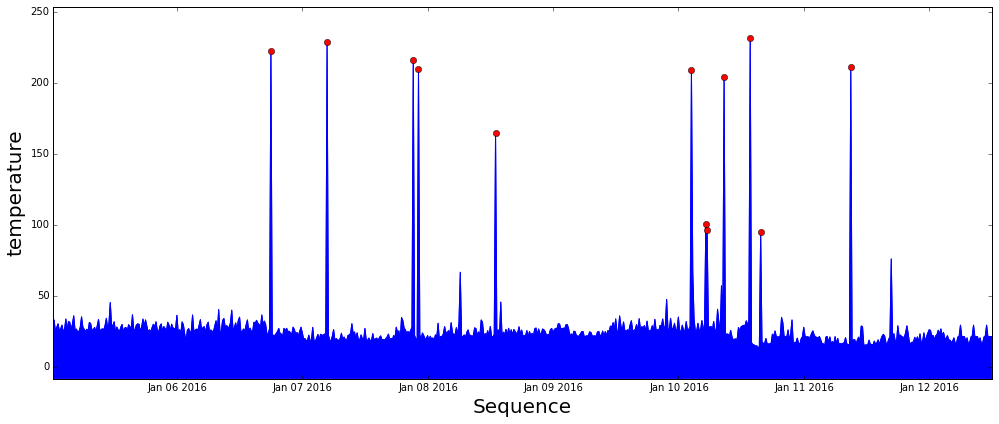

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

'''
This function detects the spike by returning a non-zero value 
when the z-score is greater than or equal to 3. Incase if you 
want to capture the smaller spikes, lower the zscore value from 
3 to 2 in this function.
'''
def spike(row):
    if(row['zscore'] >=3):
        return row[valueHeaderName]
    else:
        return 0
    
pandaDF['spike'] = pandaDF.apply(spike, axis=1)
# select rows that are required for plotting
plotDF = pandaDF[[valueHeaderName,'spike']]
#calculate the y minimum value
y_min = (pandaDF[valueHeaderName].max() - pandaDF[valueHeaderName].min()) / 10
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.set_ylim(plotDF[valueHeaderName].min() - y_min, plotDF[valueHeaderName].max() + y_min)
x_filt = plotDF.index[plotDF.spike > 0]
plotDF['xyvaluexy'] = plotDF[valueHeaderName]
y_filt = plotDF.xyvaluexy[plotDF.spike > 0]
#Plot the raw data in blue colour
line1 = ax.plot(plotDF.index, plotDF[valueHeaderName], '-', color='blue', animated = True, linewidth=1)
#plot the anomalies in red circle
line2 = ax.plot(x_filt, y_filt, 'ro', color='red', linewidth=2, animated = True)
#Fille the raw area
ax.fill_between(plotDF.index, (pandaDF[valueHeaderName].min() - y_min), plotDF[valueHeaderName], interpolate=True, color='blue')

# Label the axis
ax.set_xlabel("Sequence",fontsize=20)
ax.set_ylabel(valueHeaderName,fontsize=20)

plt.tight_layout()
plt.legend()
plt.show()

As shown, the red marks are the unexpected spikes whose z-score value is greater than 3. Incase if you want to detect the lower spikes, modify the value to 2 or even lower and run. Similarly, if you want to detect only the higher spikes, try increasing the z-score value from 3 to 4 and beyond.

### Derive threshold
Enter the following command into the next cell to derive the threshold value corresponding to z-score value 3 and click Run.

In [8]:
# calculate the value that is corresponding to z-score 3
(pandaDF[valueHeaderName].std(ddof=0) * 3) + pandaDF[valueHeaderName].mean()

93.619162226817423

This threshold value can be used to create a rule in the Watson IoT Platform to detect anomalies in the current IoT device events in realtime. This will create an alert in realtime when the current sensor reading crosses the threshold value.

###Summary
This Notebook showed how to use the z-score to detect anomalies in the historical timeseries data in simple steps. Also, showed how one can derive the threshold value for the given historical data to create a rule accordingly in IBM Watson IoT Platform. Developers can consider this Notebook as a template for detecting anomalies in their historical IoT data and modify the python code depending upon the use case.